# How to Reduce Employee Turnover

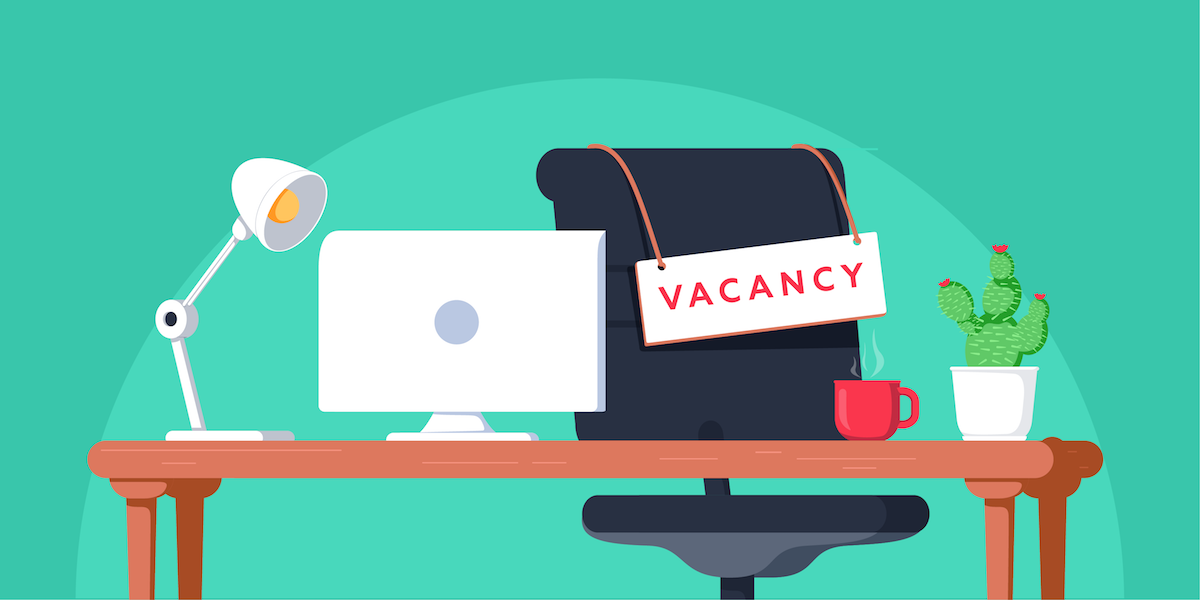

In [22]:
from IPython.display import Image
Image(filename='turnover.jpg')

## 📖 Background
In the human capital department of a large corporation, our team is tasked with reducing the relatively high turnover rate. Specifically, we want to find which variaibles impact turnover the greatest and give some ideas on how to reduce it.

## 💾 The data
The department has assembled data on almost 10,000 employees. The team used information from exit interviews, performance reviews, and employee records.

- "department" - the department the employee belongs to.
- "promoted" - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- "review" - the composite score the employee received in their last evaluation.
- "projects" - how many projects the employee is involved in.
- "salary" - for confidentiality reasons, salary comes in three tiers: low, medium, high.
- "tenure" - how many years the employee has been at the company.
- "satisfaction" - a measure of employee satisfaction from surveys.
- "bonus" - 1 if the employee received a bonus in the previous 24 months, 0 otherwise.
- "avg_hrs_month" - the average hours the employee worked in a month.
- "left" - 1 if the employee ended up leaving, 0 otherwise.

## Contents

#### Executive Summary
#### Exploratory Analysis
#### Model Selection and Methodology
#### Final Results

## Executive Summary

In this analysis, we found three strong predictors of employee turnover: satisafction, average monthly working hours, and performance review score. The +29% of employees who left the company had higher median working hours and review scores, but a similar level of satisfaction compared to those who stayed. Simply put, those who left displayed classic signs of burnout. Those working the longest hours were the most senior employees, and those with a +8 year tenure do not exceed 80 percent satisfaction.

Several things can be done to reduce burnout, including:
- Surveying employees to identify those at risk
- Reducing average monthly hours
- Encouraging mental and physical breaks
- Rewarding short-term and long-term accomplishments with bonuses and promotions
- Finding ways to increase morale

## Exploratory Analysis
- Tenure and hours worked per month have a high correlation. We also notice a correlation between review score and wheather an employee left the company (Figure 1).


- There is a large concentration of exited employees working between 185 and 190 monthly average hours. Similarly, exited employees have a higher review score, and a satisfaction rating that skews lower compared to their active counterparts (Figure 2).


- In Figure 3 can visualize the correlation between tenure and average monthly hours. The most senior employees (+12 years) work almost 200 hours a month, but we see a decline in satisfaction in turn. Interestingly, employees of more than 8 years do not have satisfaction ratings of 0.8 and up.


- Employees who left had higher median review scores, tenures, and monthly hours. However, median satisfaction is similar for both groups, at around 0.5 (Figure 4).

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from random import randint

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 9]
sns.set_style('darkgrid')
sns.set_palette('mako')

In [24]:
df = pd.read_csv('./data/employee_churn_data.csv')
# df.head()

In [25]:
print('Proportion of Employees who Quit')
print(df['left'].value_counts('yes'))

Proportion of Employees who Quit
no     0.708176
yes    0.291824
Name: left, dtype: float64


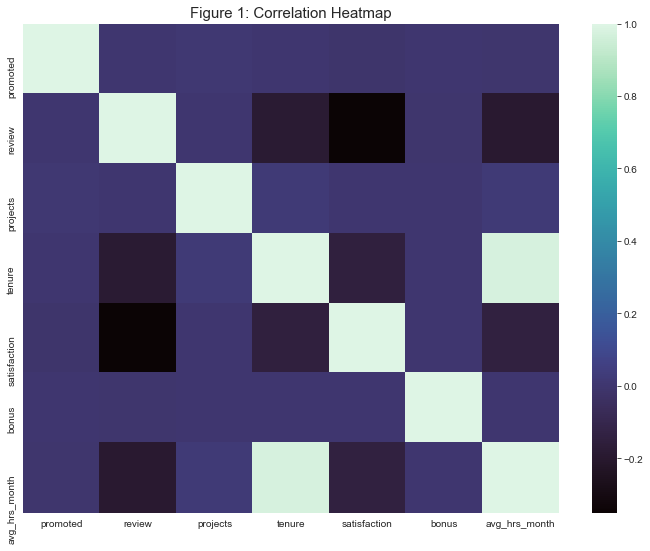

In [26]:
sns.heatmap(df.corr(), cmap='mako')
plt.title('Figure 1: Correlation Heatmap', fontsize=15)
plt.show()

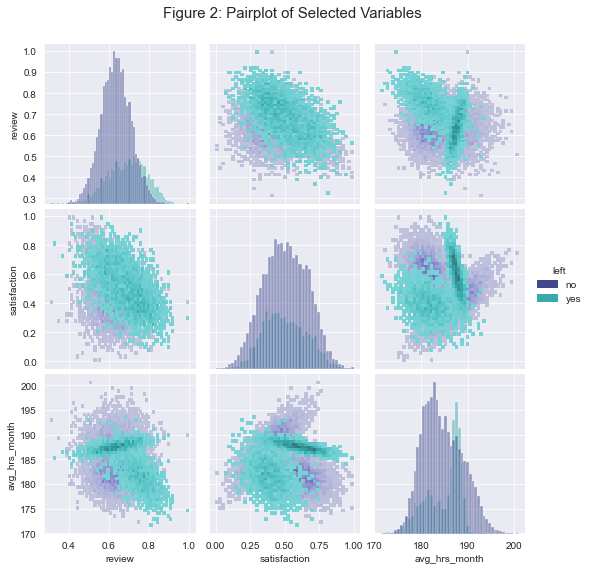

In [27]:
plot = sns.pairplot(df, vars=['review','satisfaction','avg_hrs_month'], kind='hist',hue='left',palette='mako')
plot.fig.suptitle("Figure 2: Pairplot of Selected Variables", y=1.05, fontsize=15)
plt.show()

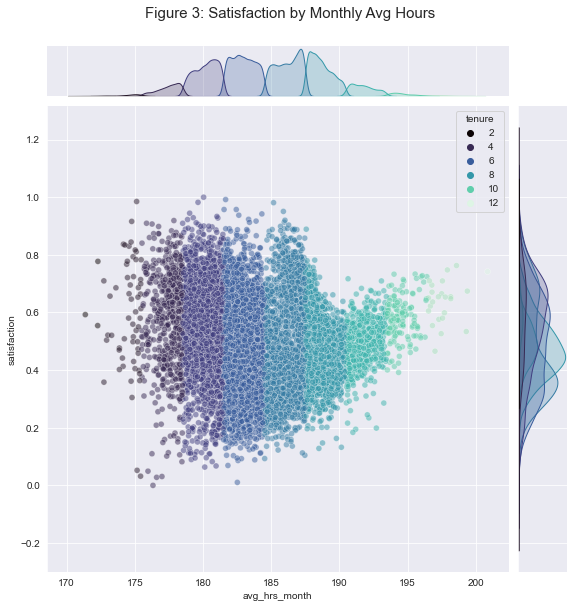

In [28]:
plot = sns.jointplot(x='avg_hrs_month', y='satisfaction', hue='tenure',palette='mako',alpha=0.5, data=df, height=8, ratio=8)
plot.fig.suptitle('Figure 3: Satisfaction by Monthly Avg Hours', y=1.05, fontsize=15)
plt.show()

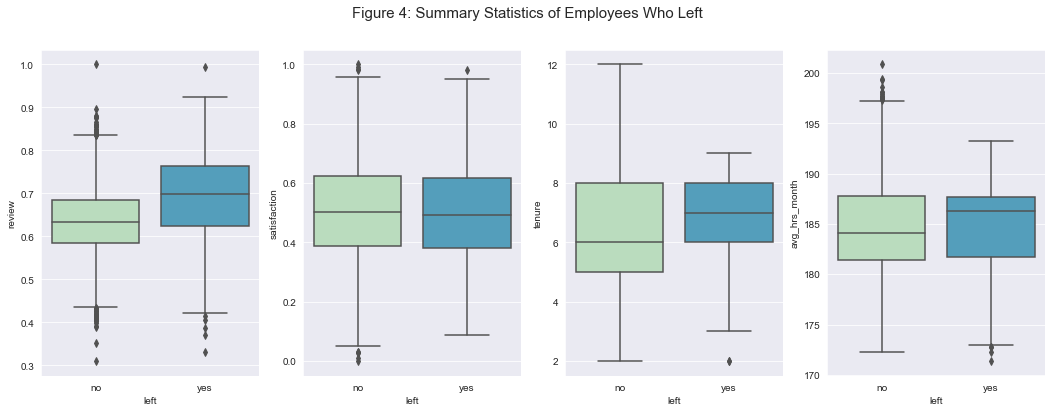

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize = (18,6)) 
fig.suptitle('Figure 4: Summary Statistics of Employees Who Left', fontsize=15)

sns.boxplot(x='left', y='review', data=df, palette='GnBu', ax=axes[0])
sns.boxplot(x='left', y='satisfaction', data=df, palette='GnBu', ax=axes[1])
sns.boxplot(x='left', y='tenure', data=df, palette='GnBu', ax=axes[2])
sns.boxplot(x='left', y='avg_hrs_month', data=df, palette='GnBu', ax=axes[3])

plt.show()

## Model Selection and Methodology


First, we create a function that scores our candidate models using 5-fold cross calidation. The metrics are:
- Accuracy
- F1 score
- Precision
- Recall
- ROC-AUC score

Then, we dummy encode categorical variables and select 10 percent of data as a hold-out set for final testing. We then score 4 models and select the best 2, tune their hyperparameters, and choose a final model.

After making a final selection, we look at the confusion matrix and assess feature importances.

In [30]:
def get_cv_scores(models, names, features, labels):
    """takes a list of models, list of their names, matrix of features, and array of labels
    and returns a dataframe of their performance scores using the sklearn.model_selection.cross_validate() function"""
    
    acc_means = []
    f1_means = []
    precision_means = []
    recall_means = []
    auc_means = []
    
    score_list = {'acc': 'accuracy',
           'f1': 'f1',
           'precision': 'precision',
           'recall':'recall',
           'AUC':'roc_auc' }
    
    for i in models:
        results = cross_validate(i, features, labels, scoring = score_list)
        acc_means.append(results.get('test_acc').mean())
        f1_means.append(results.get('test_f1').mean())
        precision_means.append(results.get('test_precision').mean())
        recall_means.append(results.get('test_recall').mean())
        auc_means.append(results.get('test_AUC').mean())
        
    frame = pd.DataFrame({'model': names})
    frame['mean_accuracy'] = acc_means
    frame['mean_f1'] = f1_means
    frame['mean_precision'] = precision_means
    frame['mean_recall'] = recall_means
    frame['mean_roc_auc'] = auc_means
    
    return frame

In [31]:
# one hot encode and test several models using get_cv_scores and scale feature matrix
df = df.replace({'no':0, 'yes':1})
dummydf = pd.get_dummies(df)

X = dummydf.drop('left', axis='columns')
y=dummydf['left']

X_train, X_test, y_train ,y_test = train_test_split(X, y, stratify = y, test_size = 0.1, random_state = 7)

# instantiate caididate models and score them in following dataframe
KNN = KNeighborsClassifier()
tree = DecisionTreeClassifier()
forest = RandomForestClassifier(n_estimators=100)
ada = AdaBoostClassifier(n_estimators=100)

names = ['KNeighbors','Decision Tree','Random Forest','AdaBoost']
scores = get_cv_scores([KNN, tree, forest, ada], names, X_train, y_train)
scores

,model,mean_accuracy,mean_f1,mean_precision,mean_recall,mean_roc_auc
0,KNeighbors,0.738410,0.488521,0.569661,0.428170,0.722075
1,Decision Tree,0.817843,0.691955,0.683530,0.701128,0.783541
2,Random Forest,0.859771,0.737681,0.812330,0.675976,0.916589
3,AdaBoost,0.770440,0.527990,0.660085,0.440139,0.846816


Using a random forest classifier is the best choice because it has the highest accuracy, f1, precision, and ROC-AUC scores, taken as the average of 5 tests via 5-fold cross validation. The desicion tree model scored second highest in accuracy, f1, and precision and had the highest score in recall.

We will tune both models and score them again to select a final choice:

In [32]:

param_dists = { 
    'n_estimators': np.int_(np.linspace(200,700,10)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.int_(np.linspace(5,50,45)),
    'criterion' :['gini', 'entropy']
}

forest_rs = RandomizedSearchCV(estimator=forest, param_distributions=param_dists, cv= 5, scoring = 'f1')
forest_rs.fit(X_train, y_train)
print(forest_rs.best_params_)

{'n_estimators': 366, 'max_features': 'auto', 'max_depth': 40, 'criterion': 'gini'}


In [33]:
param_dists = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.int_(np.linspace(5,50,45)),
    'criterion' :['gini', 'entropy']
}

tree_rs = RandomizedSearchCV(estimator=tree, param_distributions=param_dists, cv= 5, scoring = 'f1')
tree_rs.fit(X_train, y_train)
print(tree_rs.best_params_)

{'max_features': 'auto', 'max_depth': 15, 'criterion': 'gini'}


In [34]:
rs_results = get_cv_scores([forest_rs.best_estimator_, tree_rs.best_estimator_], ['Random Forest','Decision Tree'], X_train, y_train)
rs_results

,model,mean_accuracy,mean_f1,mean_precision,mean_recall,mean_roc_auc
0,Random Forest,0.860004,0.739293,0.810474,0.679968,0.919706
1,Decision Tree,0.804102,0.654619,0.675004,0.636484,0.788360


## Final Results

Since the random forest classifier has a higher score in all tests, we will use this model as our final selection. Below is the confusion matrix when run on the test set.

There were about 40 Type I errors (false positives) and roughly 80 Type II errors (false negatives). In this case positive meaning the employee left the company.vThe true positive rate (recall) was ~83.3 percent, and the positive predictive rate (precision) was ~71.6 percent.

Figure 6 shows the most important predictors of our model. Satisfaction, review score, and average monthly hours had the highest relative importance.

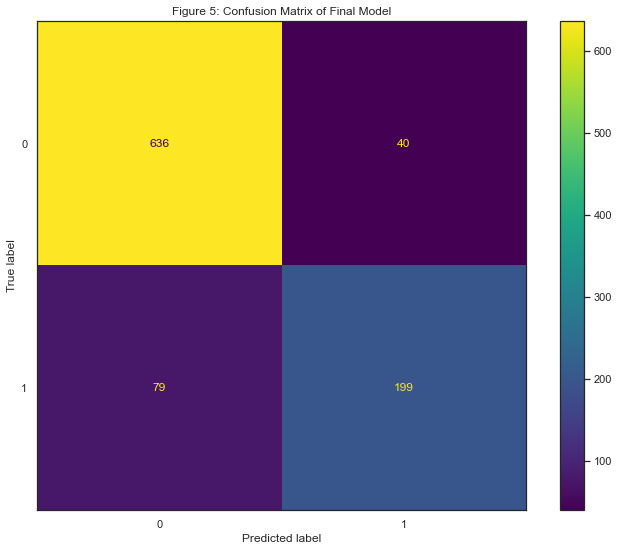

In [35]:
final_model = forest_rs.best_estimator_
y_pred = final_model.predict(X_test)

sns.set_theme(style='white')
cm = confusion_matrix(y_test, y_pred, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)

disp.plot()
plt.title('Figure 5: Confusion Matrix of Final Model')
plt.show()

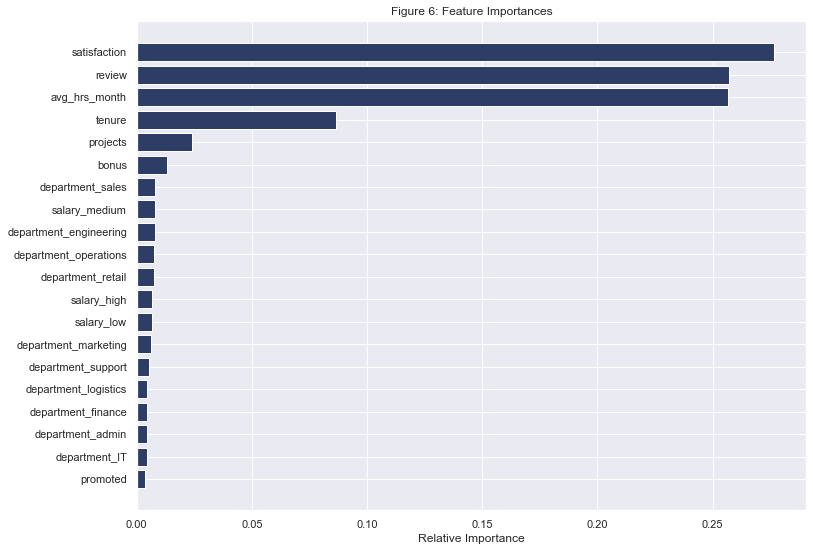

In [36]:
imps = final_model.feature_importances_

features = list(X.columns)
indices = np.argsort(imps)

sns.set_theme(style='darkgrid')
plt.title('Figure 6: Feature Importances')
plt.barh(range(len(indices)), imps[indices], color='#2d3d65', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()